# Latar Belakang

Sekarang jual beli tidak hanya dilakukan melalui pasar konvensional namun juga sudah merambah lewat dunia digital. Begitupun untuk jual beli bahan pangan seperti sayuran. Bisa dilakukan dengan mudah dimanapun dan kapanpun. Oleh karena itu penyedia aplikasi perlu menyusun daftar jual sayuran secara akurat dan sesuai untuk mempermudah para pembeli. Namun dengan semakin banyaknya jenis sayuran yang dijual maka untuk mengelompokkan jenis sayuran nya secara manual akan memerlukan waktu yang cukup lama, sehingga untuk mengatasi hal tersebut bisa mengaplikasikan *image classification* pada data gambar yang diupload. Untuk bisa mengelompokkan suatu sayuran yang dijual secara otomatis ke suatu kelompok tertentu maka diperlukan model yang bisa mengenali jenis sayuran yang terdapat pada suatu gambar. Pada Project ini akan mencoba mengklasifikasi gambar sayuran yang terdiri dari banyak kelas

In [1]:
import os
import random
import time
import shutil
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Dataset

Dataset yang digunakan merupakan data gambar sayuran yang di unduh dari [kaggle](https://www.kaggle.com/misrakahmed/vegetable-image-dataset)

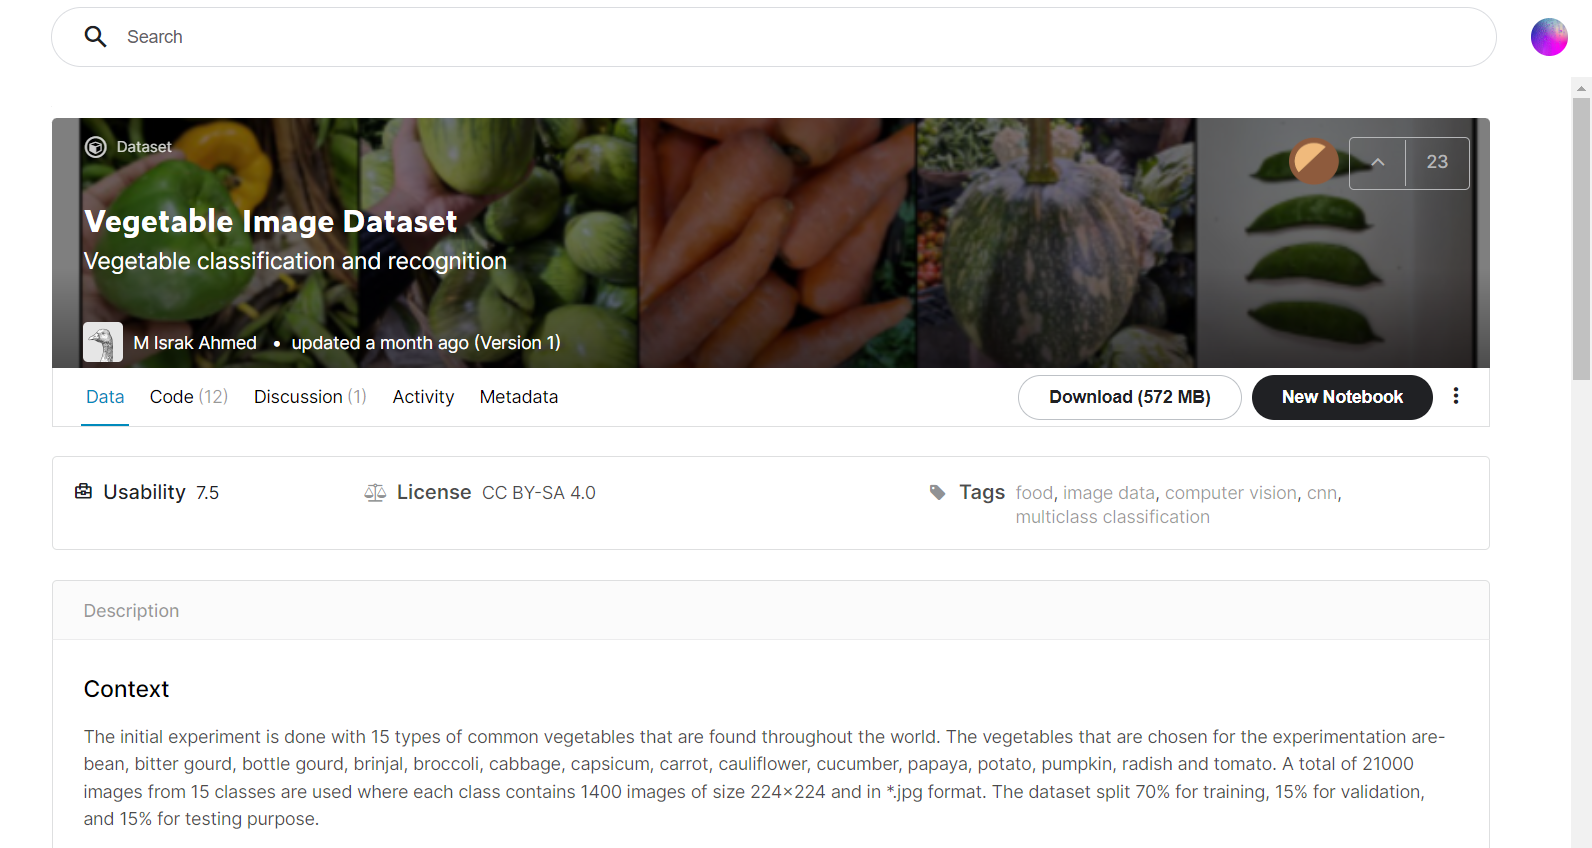

# Eksplorasi Data Analisis

In [2]:
test_path = './data/Vegetable Image Dataset/Vegetable Images/test'  # akses path untuk data test
train_path = './data/Vegetable Image Dataset/Vegetable Images/train'  # akses path untuk data train

Berikut adalah fungsi untuk menghitung jumlah data pada setiap folder kategori

In [3]:
def number_of_files(path):
    total = []
    for folder in os.listdir(path):
        files = []
        for file in os.listdir(os.path.join(path, folder)):
            files.append(file)
            total.append(file)
        print(f'{folder}: ', len(files))
    print('Total Images :', len(total))

In [4]:
number_of_files(train_path)

Bean:  1000
Bitter_Gourd:  1000
Bottle_Gourd:  1000
Brinjal:  1000
Broccoli:  1000
Cabbage:  1000
Capsicum:  1000
Carrot:  1000
Cauliflower:  1000
Cucumber:  1000
Papaya:  1000
Potato:  1000
Pumpkin:  1000
Radish:  1000
Tomato:  1000
Total Images : 15000


Pada data latih terdapat 15000 data gambar dengan masing-masing kelas terdapat 1000 gambar

In [5]:
number_of_files(test_path)

Bean:  200
Bitter_Gourd:  200
Bottle_Gourd:  200
Brinjal:  200
Broccoli:  200
Cabbage:  200
Capsicum:  200
Carrot:  200
Cauliflower:  200
Cucumber:  200
Papaya:  200
Potato:  200
Pumpkin:  200
Radish:  200
Tomato:  200
Total Images : 3000


Pada data percobaan terdapat 3000 data gambar dengan masing-masing kelas terdapat 200 gambar

Untuk lebih memudahkan pemrosesan maka nama berkas gambar pada tiap folder kelas dirubah sesuai dengan nama folder tersebut dan kemudian dipindahkan ke suatu folder baru yaitu folder `train_data` dan `test_data`

In [6]:
os.mkdir('./data/Vegetable Image Dataset/Vegetable Images/train_data') # membuat folder untuk data latih
os.mkdir('./data/Vegetable Image Dataset/Vegetable Images/test_data') # membuat folder untuk data percobaan

In [7]:
def rename_file(directory):
    
    for folder in os.listdir(directory):
        files = os.listdir(os.path.join(directory, folder))

        for file in files:
            os.rename(os.path.join(os.path.join(directory, f'{folder}'), f'{file}'),
                      os.path.join(os.path.join(directory, f'{folder}'), f'{folder}.{file}'))

def copy_file(dir, type):
    for folder in os.listdir(dir):
        for file in os.listdir(os.path.join(dir, folder)):
            if type == 'train':
                shutil.copy(os.path.join(os.path.join(dir, f'{folder}'), f'{file}'),
                            './data/Vegetable Image Dataset/Vegetable Images/train_data')
            else:
                shutil.copy(os.path.join(os.path.join(dir, f'{folder}'), f'{file}'),
                            './data/Vegetable Image Dataset/Vegetable Images/test_data')

In [8]:
rename_file(test_path)
rename_file(train_path)

copy_file(test_path, type='test')
copy_file(train_path, type='train')

Sebelum dilatih data gambar mesti dirubah dari channel BGR menjadi RGB

In [9]:
def load_rgb_image(image):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [10]:
train_data = os.listdir('./data/Vegetable Image Dataset/Vegetable Images/train_data')
test_data = os.listdir('./data/Vegetable Image Dataset/Vegetable Images/test_data')

In [11]:
train_image = {
    file: load_rgb_image('./data/Vegetable Image Dataset/Vegetable Images/train_data/{}'.format(file))
    for file in train_data
}

test_image = {
    file: load_rgb_image('./data/Vegetable Image Dataset/Vegetable Images/test_data/{}'.format(file))
    for file in test_data
}

Fungsi berikut digunakan untuk menampilkan data gambar yang diambil secara acak dari folder training dan testing

In [12]:
def show_n_train_images(n):
    n_cols = n // 2
    sample_img = random.sample(list(train_image.items()), n)
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols*5, 6))
    for axis, img in zip(ax.flatten(), sample_img):
        axis.imshow(img[1])
        axis.set_title(f"{img[0].split('.')[0].title()} - {img[0]}")
        axis.set_yticks([])
        axis.set_xticks([])
    plt.show()

def show_n_test_images(n):
    n_cols = n // 2
    sample_img = random.sample(list(test_image.items()), n)
    fig, ax = plt.subplots(2, n_cols, figsize=(n_cols*5, 6))
    for axis, img in zip(ax.flatten(), sample_img):
        axis.imshow(img[1])
        axis.set_title(f"{img[0].split('.')[0].title()} - {img[0]}")
        axis.set_yticks([])
        axis.set_xticks([])
    plt.show()

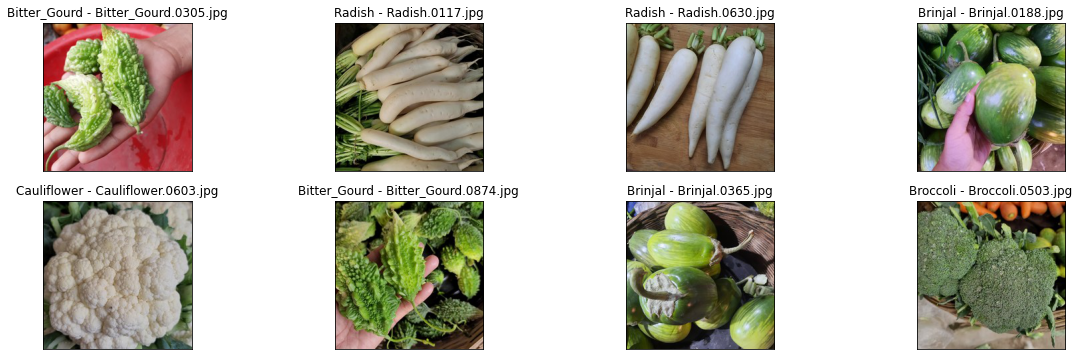

In [13]:
show_n_train_images(8)

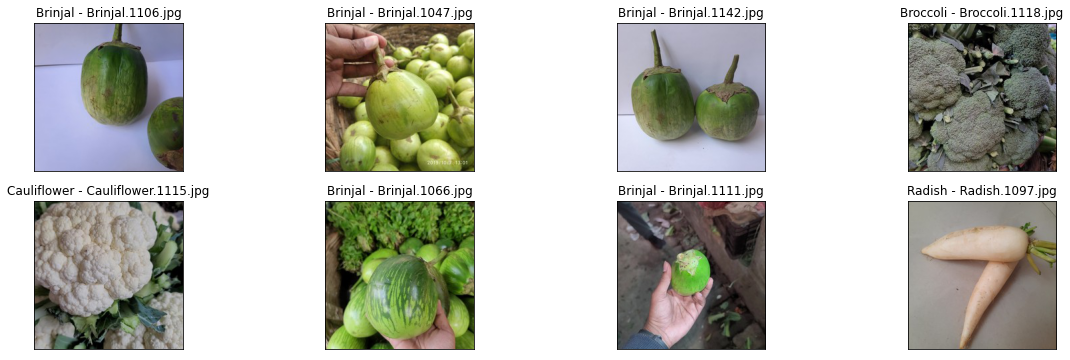

In [14]:
show_n_test_images(8)

# Pemrosesan Data

## Train Data

Ukuran data gambar tiap gambar dirubah untuk mengurangi jumlah fitur agar waktu komputasi nya relatif lebih cepat

In [15]:
image_dim = (64, 64)
for filename, image in train_image.items():
    train_image[filename] = cv2.resize(image, image_dim)

Defisikan target variable dan fitur gambar yang akan digunakan untuk training. target dan fitur dapat diperoleh dari dictionary `train_image`

In [16]:
train_targets = [
    filename.split(".")[0]
    for filename in train_image.keys()
]

train_features = [
    cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    for img in train_image.values()
]

Disini hanya diambil 5 kelas dari total 15 kelas, karena *resource* laptop yang tidak mencukupi. 5 kelas yang dipakai adalah `'Bean'`, `'Bitter_Gourd'`, `'Bottle_Gourd'`, `'Brinjal'`, `'Broccoli'`

In [17]:
# train_features = np.array(train_features[2000:9000])
# train_targets = train_targets[2000:9000]

train_features = np.array(train_features[:5000])
train_targets = train_targets[:5000]

In [18]:
# print('train_targets :', np.unique(train_targets[2000:9000]))
# print('train_features :',train_features.shape)

print('train_targets :', np.unique(train_targets[:5000]))
print('train_features :',train_features.shape)

train_targets : ['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli']
train_features : (5000, 64, 64)


Data gambar hanya menggunakan satu channel agar fitur nya berkurang

Fitur gambar perlu dirubah menjadi array 2D agar bisa dilatih

In [19]:
train_features = train_features.reshape((train_features.shape[0], -1))
print('train_features :',train_features.shape)

train_features : (5000, 4096)


## Test Data

In [20]:
image_dim = (64, 64)
for filename, image in test_image.items():
    test_image[filename] = cv2.resize(image, image_dim)

In [21]:
test_targets = [
    filename.split(".")[0]
    for filename in test_image.keys()
]

test_features = [
    cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    for img in test_image.values()
]

In [22]:
# test_features = np.array(test_features[400:1800])
# test_targets = test_targets[400:1800]

test_features = np.array(test_features[:1000])
test_targets = test_targets[:1000]

In [23]:
# print('test_targets :', np.unique(test_targets[400:1800]))
# print('test_features :',test_features.shape)

print('test_targets :', np.unique(test_targets[:1000]))
print('test_features :',test_features.shape)

test_targets : ['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli']
test_features : (1000, 64, 64)


In [24]:
test_features = test_features.reshape((test_features.shape[0], -1))
print('train_features :',test_features.shape)

train_features : (1000, 4096)


#  Model

Model yang digunakan untuk percobaan ini adalah model logistic regression, SVC, Decision Tree, dan Random forest. Tiap model menggunakan parameter *default*

## Pemilihan Model

### Logistic Regression

In [25]:
lr = LogisticRegression(max_iter=2000)

# training
start_time = time.time()
lr.fit(train_features, train_targets)
print(f"Training time : {time.time() - start_time:.3f} s")

# prediction
start_time = time.time()
lr_pred_train = lr.predict(train_features)
lr_pred_test = lr.predict(test_features)
print(f"Prediction time : {time.time() - start_time:.3f} s")

Training time : 198.170 s
Prediction time : 0.124 s


D:\Users\Dimasprd\miniconda3\envs\Bitlabs\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### SVM

In [26]:
svc = SVC()

# training
start_time = time.time()
svc.fit(train_features, train_targets)
print(f"Training time : {time.time() - start_time:.3f} s")

# prediction
start_time = time.time()
svc_pred_train = svc.predict(train_features)
svc_pred_test = svc.predict(test_features)
print(f"Prediction time : {time.time() - start_time:.3f} s")

Training time : 99.971 s
Prediction time : 149.130 s


### Decision Tree

In [27]:
dtree = DecisionTreeClassifier()

# training
start_time = time.time()
dtree.fit(train_features, train_targets)
print(f"Training time : {time.time() - start_time:.3f} s")

# prediction
start_time = time.time()
dtree_pred_train = dtree.predict(train_features)
dtree_pred_test = dtree.predict(test_features)
print(f"Prediction time : {time.time() - start_time:.3f} s")

Training time : 19.891 s
Prediction time : 0.080 s


### Random Forest

In [28]:
rf = RandomForestClassifier()

# training
start_time = time.time()
rf.fit(train_features, train_targets)
print(f"Training time : {time.time() - start_time:.3f} s")

# prediction
start_time = time.time()
rf_pred_train = rf.predict(train_features)
rf_pred_test = rf.predict(test_features)
print(f"Prediction time : {time.time() - start_time:.3f} s")

Training time : 19.102 s
Prediction time : 0.434 s


## Evaluasi Model

### Logistic Regression

In [29]:
print(
    "Logistic Regression's Performance on training set:",
    classification_report(train_targets, lr_pred_train),
    sep="\n"
)
print(
    "Logistic Regression's Performance on testing set:",
    classification_report(test_targets, lr_pred_test),
    sep="\n"
)

Logistic Regression's Performance on training set:
              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00      1000
Bitter_Gourd       1.00      1.00      1.00      1000
Bottle_Gourd       1.00      1.00      1.00      1000
     Brinjal       1.00      1.00      1.00      1000
    Broccoli       1.00      1.00      1.00      1000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Logistic Regression's Performance on testing set:
              precision    recall  f1-score   support

        Bean       0.43      0.47      0.45       200
Bitter_Gourd       0.57      0.39      0.46       200
Bottle_Gourd       0.47      0.60      0.53       200
     Brinjal       0.44      0.51      0.47       200
    Broccoli       0.49      0.41      0.45       200

    accuracy                           0.48      1000
   macro avg       0.48      0

### SVM

In [30]:
print(
    "SVC's Performance on training set:",
    classification_report(train_targets, svc_pred_train),
    sep="\n"
)
print(
    "SVC's Performance on testing set:",
    classification_report(test_targets, svc_pred_test),
    sep="\n"
)

SVC's Performance on training set:
              precision    recall  f1-score   support

        Bean       0.95      0.97      0.96      1000
Bitter_Gourd       0.98      0.97      0.98      1000
Bottle_Gourd       1.00      0.97      0.98      1000
     Brinjal       0.97      0.97      0.97      1000
    Broccoli       0.95      0.97      0.96      1000

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

SVC's Performance on testing set:
              precision    recall  f1-score   support

        Bean       0.74      0.76      0.75       200
Bitter_Gourd       0.83      0.84      0.84       200
Bottle_Gourd       0.95      0.97      0.96       200
     Brinjal       0.84      0.84      0.84       200
    Broccoli       0.86      0.81      0.83       200

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted

### Decision Tree

In [31]:
print(
    "Decision Tree's Performance on training set:",
    classification_report(train_targets, dtree_pred_train),
    sep="\n"
)
print(
    "Decision Tree's Performance on testing set:",
    classification_report(test_targets, dtree_pred_test),
    sep="\n"
)

Decision Tree's Performance on training set:
              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00      1000
Bitter_Gourd       1.00      1.00      1.00      1000
Bottle_Gourd       1.00      1.00      1.00      1000
     Brinjal       1.00      1.00      1.00      1000
    Broccoli       1.00      1.00      1.00      1000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Decision Tree's Performance on testing set:
              precision    recall  f1-score   support

        Bean       0.54      0.49      0.52       200
Bitter_Gourd       0.54      0.50      0.52       200
Bottle_Gourd       0.59      0.67      0.62       200
     Brinjal       0.55      0.57      0.56       200
    Broccoli       0.48      0.48      0.48       200

    accuracy                           0.54      1000
   macro avg       0.54      0.54      0.5

### Random Forest

In [32]:
print(
    "Random Forest's Performance on training set:",
    classification_report(train_targets, rf_pred_train),
    sep="\n"
)
print(
    "Random Forest's Performance on testing set:",
    classification_report(test_targets, rf_pred_test),
    sep="\n"
)

Random Forest's Performance on training set:
              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00      1000
Bitter_Gourd       1.00      1.00      1.00      1000
Bottle_Gourd       1.00      1.00      1.00      1000
     Brinjal       1.00      1.00      1.00      1000
    Broccoli       1.00      1.00      1.00      1000

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000

Random Forest's Performance on testing set:
              precision    recall  f1-score   support

        Bean       0.80      0.67      0.73       200
Bitter_Gourd       0.72      0.85      0.78       200
Bottle_Gourd       0.93      0.95      0.94       200
     Brinjal       0.85      0.78      0.81       200
    Broccoli       0.77      0.81      0.79       200

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.8

## Penentuan Model Terbaik

In [33]:
max_depth = (5, 10)
min_samples_split = (2, 5, 10)

grid_search = GridSearchCV(
    rf,
    param_grid={
        "max_depth": max_depth,
        "min_samples_split": min_samples_split,
    }
)
grid_search.fit(train_features, train_targets)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': (5, 10), 'min_samples_split': (2, 5, 10)})

In [34]:
grid_search.best_params_

{'max_depth': 10, 'min_samples_split': 5}

In [35]:
grid_search.best_estimator_

RandomForestClassifier(max_depth=10, min_samples_split=5)

In [36]:
print(
    "Random Forest's Performance on testing set (not using Grid Search)",
    classification_report(test_targets, rf_pred_test),
    sep="\n"
)
print(
    "Random Forest's Performance on testing set (using Grid Search)",
    classification_report(test_targets, grid_search.predict(test_features)),
    sep="\n"
)

Random Forest's Performance on testing set (not using Grid Search)
              precision    recall  f1-score   support

        Bean       0.80      0.67      0.73       200
Bitter_Gourd       0.72      0.85      0.78       200
Bottle_Gourd       0.93      0.95      0.94       200
     Brinjal       0.85      0.78      0.81       200
    Broccoli       0.77      0.81      0.79       200

    accuracy                           0.81      1000
   macro avg       0.82      0.81      0.81      1000
weighted avg       0.82      0.81      0.81      1000

Random Forest's Performance on testing set (using Grid Search)
              precision    recall  f1-score   support

        Bean       0.78      0.66      0.71       200
Bitter_Gourd       0.73      0.88      0.80       200
Bottle_Gourd       0.92      0.90      0.91       200
     Brinjal       0.86      0.78      0.82       200
    Broccoli       0.73      0.80      0.77       200

    accuracy                           0.80      1000
 

## Percobaan Klasifikasi

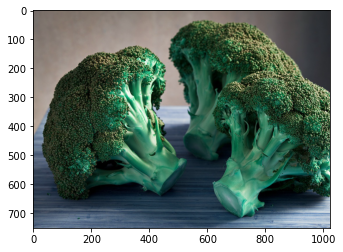

In [37]:
image = cv2.imread('broccoli.jpg')
img = load_rgb_image('broccoli.jpg')
img_ = cv2.resize(img, (64, 64))

plt.imshow(image)
plt.show()

In [38]:
imgs = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)
broccoli_features = np.array(imgs)
svc_pred_test = svc.predict(broccoli_features.reshape(1, -1))

In [39]:
print('Jenis Sayuran :', svc_pred_test[0])

Jenis Sayuran : Broccoli


Prediksi model benar

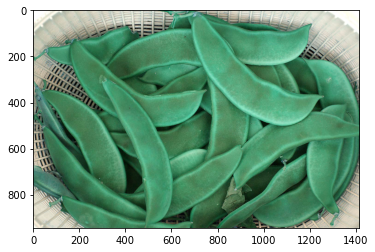

In [40]:
image = cv2.imread('bean.jpg')
bean_img = load_rgb_image('bean.jpg')
bean = cv2.resize(bean_img, (64, 64))

plt.imshow(image)
plt.show()

In [41]:
imgs = cv2.cvtColor(bean, cv2.COLOR_RGB2GRAY)
bean_features = np.array(imgs)
svc_pred_test = svc.predict(bean_features.reshape(1, -1))

In [42]:
print('Jenis Sayuran :', svc_pred_test[0])

Jenis Sayuran : Broccoli


Prediksi model salah

## Interpretasi Hasil

Pada hasil diatas, model yang memiliki akurasi yang cukup baik adalah model SVM dengan akurasi sebesar 84%. Diikuti oleh model Random Forest dengan akurasi sebesar 0.79% sedangkan model Logistic Regression dan Decision Tree memiliki akurasi yang sangat rendah yaitu dibawah 50%. Untuk model Random forest dilakukan Hyperparameter tuning menggunakan GridSearch untuk mendapatkan hasil yang maksimal namun akurasi yang dihasilkan hanya 72% lebih rendah jika dibandingkan tanpa GridSearch (mungkin disebabkan karena rentang nilai untuk parameter nya kurang sesuai)

# Kesimpulan & *Future Works*

Pada kasus ini model SVM menghasilkan model dengan akurasi yang terbaik yaitu 84%. Untuk *future works* nya mungkin akan melakukan hyperparameter tuning yang lebih banyak agar mendapatkan hasil yang optimal dan juga mengimplementasikan teknik lain seperti *Neural Network* untuk mengklasifikasikan gambar 